<a href="https://colab.research.google.com/github/abdumhmd/kvasir-segmentation/blob/main/UNet_Vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!unzip /content/drive/MyDrive/kvasir-seg.zip

In [2]:
!pip install segmentation-models

     |████████████████████████████████| 50 kB 3.4 MB/s 


In [3]:
import os

!mkdir /content/Kvasir-SEG/images/img
!mv /content/Kvasir-SEG/images/*.jpg /content/Kvasir-SEG/images/img
!mkdir /content/Kvasir-SEG/masks/img
!mv /content/Kvasir-SEG/masks/*.jpg /content/Kvasir-SEG/masks/img
images=os.listdir('/content/Kvasir-SEG/images/img')
masks=os.listdir('/content/Kvasir-SEG/masks/img')

print(len(images))
print(len(masks))

1000
1000


(529, 570, 3)

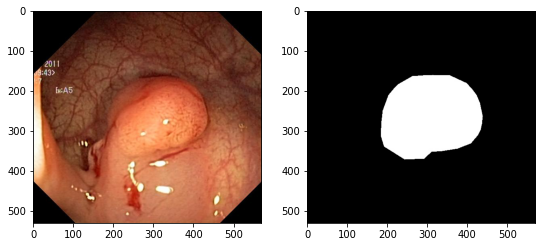

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2)
fig.set_size_inches(9, 9)

img=plt.imread("/content/Kvasir-SEG/images/img/"+images[0])
msk=plt.imread("/content/Kvasir-SEG/masks/img/"+masks[0])
axs[0].imshow(img)
axs[1].imshow(msk)

msk.shape


In [15]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
from tqdm import tqdm
import numpy as np


images_ = []
masks_ =  []
size=(256,256)
for i in tqdm(os.listdir('/content/Kvasir-SEG/images/img/')):
    
    

    img_name = "/content/Kvasir-SEG/images/img/"+ i 
    img_mask = "/content/Kvasir-SEG/masks/img/" + i 
    
    
    
    img = load_img(img_name, target_size=size)
    img = img_to_array(img)/255.
    
    mask = load_img(img_mask, target_size=size,color_mode="grayscale")
    mask = img_to_array(mask)/255.
    images_.append(img)
    masks_.append(mask)
    
images_ =  np.array(images_)
masks_ = np.array(masks_)
print(images_.shape, masks_.shape)
filename = 'maps_256.npz'
#savez_compressed(filename, images_, masks_)

100%|██████████| 1000/1000 [00:12<00:00, 82.68it/s]


(1000, 256, 256, 3) (1000, 256, 256, 1)


In [17]:
from numpy import load

#filename = 'maps_256.npz'
# Load training and testing data
#datatrain = load(filename)
X_train, y_train = images_, masks_


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(X_train.shape,X_test.shape,X_valid.shape)

(600, 256, 256, 3) (200, 256, 256, 3) (200, 256, 256, 3)


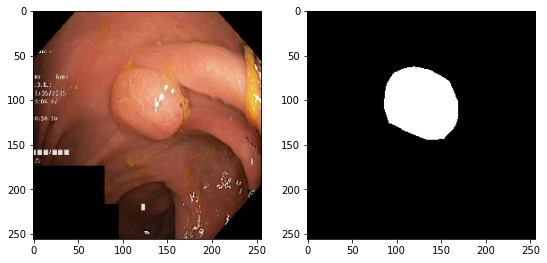

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2)
fig.set_size_inches(9, 9)

axs[0].imshow(X_train[100])
#axs[1].imshow(y_train[55])
axs[1].imshow(np.reshape(y_train[100], (256, 256)), cmap="gray");

In [21]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model


input_shape = (256, 256, 3)
model = build_vgg16_unet(input_shape)
model.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [22]:
from segmentation_models.metrics import IOUScore,FScore
from segmentation_models.losses import JaccardLoss,DiceLoss
import tensorflow as tf

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as keras

def IoU(y_pred, y_true):
    I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
    U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
    return tf.reduce_mean(I / U)

def IoU_loss(y_pred, y_true):
    return 1-IoU(y_pred,y_true)

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
  denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

  return 1 - (numerator + 1) / (denominator + 1)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=DiceLoss(), 
           metrics = [IOUScore(threshold=.5),FScore(threshold=.5),'binary_accuracy', 'AUC'])

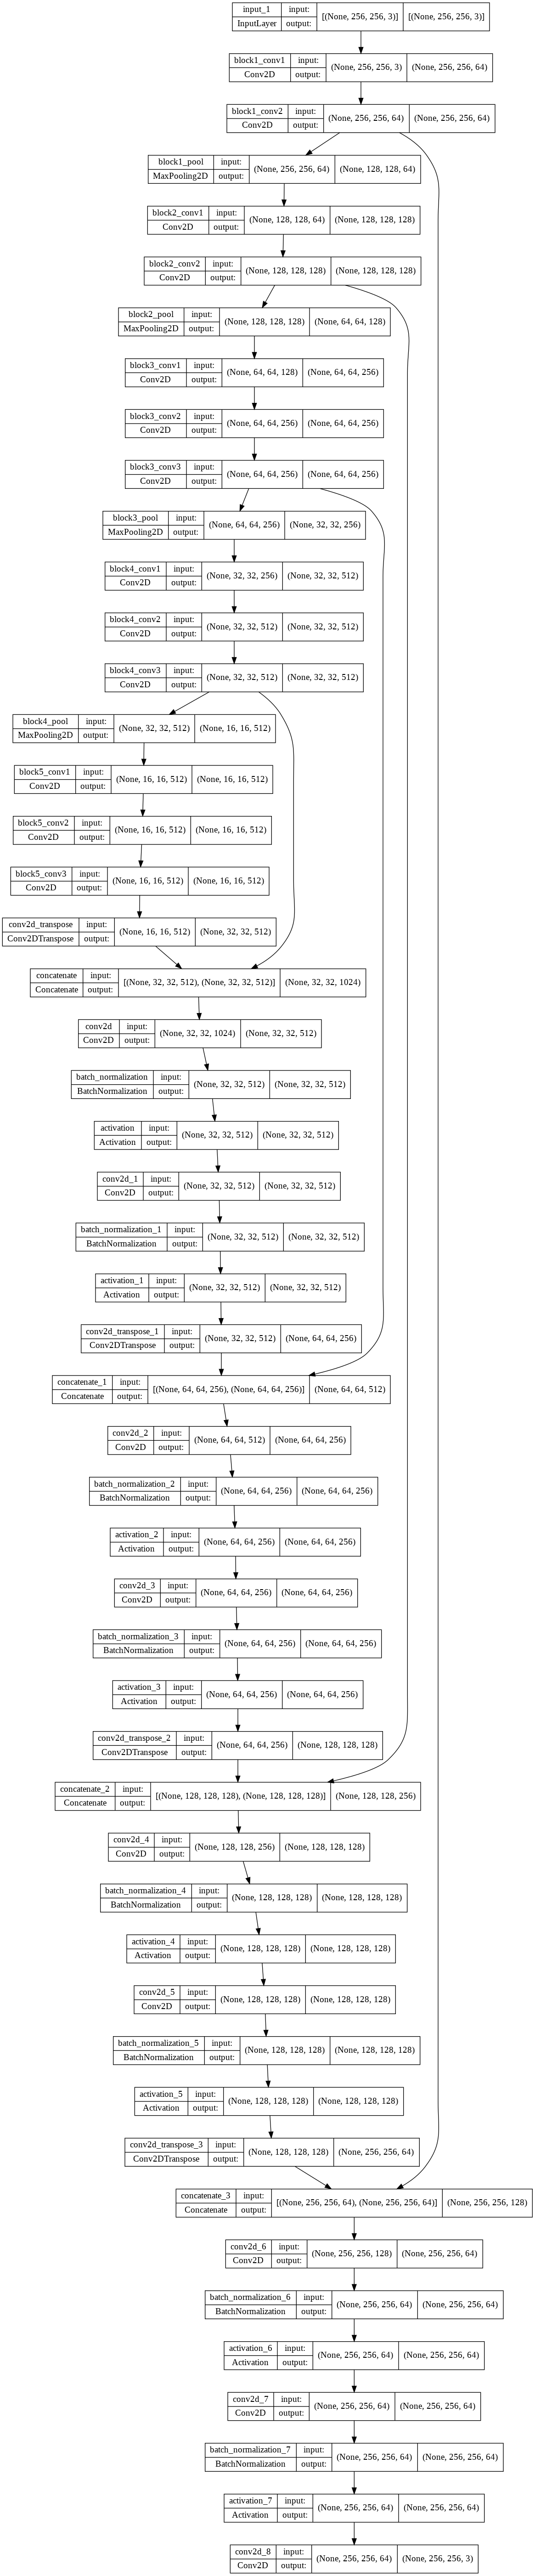

In [ ]:
tf.keras.utils.plot_model(
    model, show_shapes=True, 
    show_layer_names=True
)

In [24]:
import time

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau,TensorBoard
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=10,
                                   verbose=1, mode='min', min_delta=0.0002, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=20) # probably needs to be more patient, but kaggle time is limited

NAME = "Unet_kvasir-seg {}".format(int(time.time()))


tfBoard=TensorBoard(log_dir='./graphs/{}'.format(NAME), histogram_freq=0,write_graph=True, write_images=True)
callbacks_list = [checkpoint, early, reduceLROnPlat,tfBoard]

In [25]:
history = model.fit(x=X_train,y=y_train,validation_data=(X_valid,y_valid), verbose=1, batch_size=32,epochs=500, callbacks=callbacks_list)

Epoch 1/500
19/19 [==============================] - ETA: 0s - loss: 0.5733 - iou_score: 0.2983 - f1-score: 0.4539 - binary_accuracy: 0.6934 - auc: 0.8035
Epoch 1: val_loss improved from inf to 1.00000, saving model to cxr_reg_weights.best.hdf5
19/19 [==============================] - 55s 2s/step - loss: 0.5733 - iou_score: 0.2983 - f1-score: 0.4539 - binary_accuracy: 0.6934 - auc: 0.8035 - val_loss: 1.0000 - val_iou_score: 4.3314e-11 - val_f1-score: 4.3314e-11 - val_binary_accuracy: 0.8386 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/500
19/19 [==============================] - ETA: 0s - loss: 0.5118 - iou_score: 0.3487 - f1-score: 0.5149 - binary_accuracy: 0.7882 - auc: 0.8242
Epoch 2: val_loss improved from 1.00000 to 0.70846, saving model to cxr_reg_weights.best.hdf5
19/19 [==============================] - 34s 2s/step - loss: 0.5118 - iou_score: 0.3487 - f1-score: 0.5149 - binary_accuracy: 0.7882 - auc: 0.8242 - val_loss: 0.7085 - val_iou_score: 0.1715 - val_f1-score: 0.2926 - val_binar

In [26]:
import os
import shutil
!rm -r drive/MyDrive/graphs
shutil.copytree('/content/graphs','drive/MyDrive/graphs_UNet')

'drive/MyDrive/graphs_UNet'

In [75]:
os.mkdir('drive/MyDrive/UNet_Weights/')
shutil.copy('/content/cxr_reg_weights.best.hdf5','drive/MyDrive/UNet_Weights/UNet_Single.hdf5')

'drive/MyDrive/UNet_Weights/UNet_Single.hdf5'

In [27]:
model.load_weights('/content/cxr_reg_weights.best.hdf5')
scores=model.evaluate(X_test,y_test)
print(scores)

7/7 [==============================] - 3s 473ms/step - loss: 0.2054 - iou_score: 0.6798 - f1-score: 0.8075 - binary_accuracy: 0.9370 - auc: 0.8805
[0.20544056594371796, 0.6797677278518677, 0.8074749112129211, 0.9369606971740723, 0.8805016875267029]


97
27
152


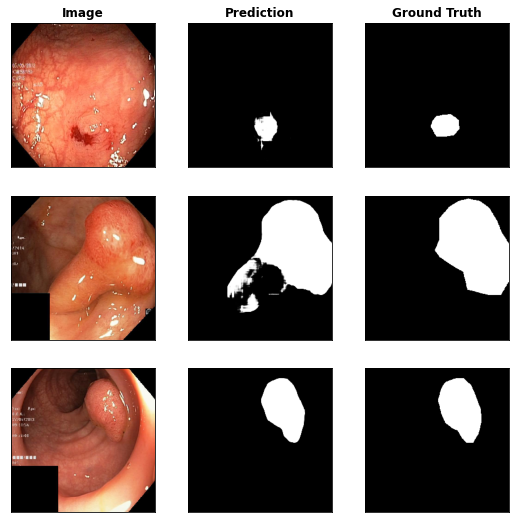

In [70]:
import random
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,3)
fig.set_size_inches(9, 9)


plt.setp(axs, xticks=[], yticks=[])

sample=random.randrange(len(X_test))
print(sample)
i=np.expand_dims(X_test[sample],axis=0)
pred=model.predict(i)

axs[0][0].imshow(X_test[sample])
axs[0][1].imshow(np.reshape(pred[0], (256, 256)), cmap="gray");
axs[0][2].imshow(np.reshape(y_test[sample], (256, 256)), cmap="gray");

sample=random.randrange(len(X_test))
print(sample)
i=np.expand_dims(X_test[sample],axis=0)
pred=model.predict(i)

axs[1][0].imshow(X_test[sample])
axs[1][1].imshow(np.reshape(pred[0], (256, 256)), cmap="gray");
axs[1][2].imshow(np.reshape(y_test[sample], (256, 256)), cmap="gray");

sample=random.randrange(len(X_test))
print(sample)
i=np.expand_dims(X_test[sample],axis=0)
pred=model.predict(i)

axs[0][0].set_title('Image',
             fontweight ="bold")
axs[0][1].set_title('Prediction',
             fontweight ="bold")
axs[0][2].set_title('Ground Truth',
             fontweight ="bold")
axs[2][0].imshow(X_test[sample])
axs[2][1].imshow(np.reshape(pred[0], (256, 256)), cmap="gray");
axs[2][2].imshow(np.reshape(y_test[sample], (256, 256)), cmap="gray");